# Resources and credit:
- SSDD data download: https://github.com/TianwenZhang0825/LS-SSDD-v1.0-OPEN
- Detectron2 docs: https://detectron2.readthedocs.io/en/latest/index.html

# Installation of detectron2 and Imports
*Standard from Detectron2's docs*

*Restart after executing this cell*

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1
!pip install torch==1.7.1 torchvision==0.8.2 torchaudio==0.7.2
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.7")
!gcc --version
# opencv is pre-installed on colab
exit(0)

     |████████████████████████████████| 276kB 18.4MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44074 sha256=e635cd869b07740cc7d7ccff0b60bfa1d6644fbfc2c7ce5ed76c0c37cf34b884
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.7.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



*Restart after executing this cell*

In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
!pip install detectron2==0.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
import detectron2
print(detectron2.__version__)
exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
     |████████████████████████████████| 6.8MB 708kB/s 
     |████████████████████████████████| 2.2MB 18.4MB/s 
     |████████████████████████████████| 51kB 8.7MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210225-cp37-none-any.whl size=52472 sha256=529ef1b197b051e3536951d9c391b4d96fd47a35451747c5ede564d0268d21d1
  Stored in directory: /root/.cache/pip/wheels/7e/74/67/d54ccca312fdc5a298141abf8328680ecaf0a1b78ae1b9a777
  Created wheel for iopath: filename=iopath-0.1.4-cp37-none-any.whl size=15571 sha256=5e9bcc523048bc333814cb024164d7b4a5cf5823816c04046e0024c77b06de3d
  Stored in directory: /root/.cache/pip/wheels/54/3b/fb/25b60ef5989e3f5fd76fdc575c922e6e59066ddbd1b44756a9
Successfully built fvcore iopath
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling 

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



# Registration of the custom dataset to detectron2

In [ ]:
# Function that retrieves a standard dataset compatible with detectron2
def get_dict(type):
  """ Returns a list[dict] containing information about the dataset """
  import pickle
  root = '/content/drive/MyDrive/SSDD/datasets/' + type + '/'
  with open(root + "standardDict.pkl", "rb") as input_file:
    return pickle.load(input_file)

In [ ]:
# Global paths
datasets = '/content/drive/MyDrive/SSDD/datasets/'

# Mount Google Drive (Import files from Google Drive in Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from detectron2.structures import BoxMode

pre = 'ssdd_'

# Register
for d in ["train", "test", "test_offshore", "test_inshore", "train/train_w_val", "train/validation", "train/toy"]:
    DatasetCatalog.register(pre + d, lambda d=d: get_dict(d))
    MetadataCatalog.get(pre + d).set(thing_classes=["ship"])

In [ ]:
# Instances of metadata
train_metadata = MetadataCatalog.get(pre + 'train')
test_metadata = MetadataCatalog.get(pre + 'test')
test_offshore_metadata = MetadataCatalog.get(pre + 'test_offshore')
test_inshore_metadata = MetadataCatalog.get(pre + 'test_inshore')
train_w_val_metadata = MetadataCatalog.get(pre + 'train/train_w_val')
validation_metadata = MetadataCatalog.get(pre + 'train/validation')
toy_metadata = MetadataCatalog.get(pre + 'train/toy')

# Copy Paste
*Create copy+paste subroutine to be used in data augmentation*

In [ ]:
import cv2
# Inspired from https://www.mdpi.com/2072-4292/12/16/2558/pdf

class copyPaste():
  def __init__(self, annotation):
    self.ann = copy.deepcopy(annotation)

  def load_image(self, image = None):
    self.image = image
    if self.image is None:
      self.image = utils.read_image(self.ann["file_name"], format="BGR")
    self.mask()

  def mask(self):
    #https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html
    FILTER = 3
    BLUR = 5
    temp = cv2.imread(self.ann["file_name"], 0)
    temp = cv2.equalizeHist(temp)
    temp = cv2.GaussianBlur(temp,(BLUR,BLUR),0)
    ret,th = cv2.threshold(temp,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    mask = np.where(th == 255, 1, 0).astype('uint8')
    kernel = np.ones((FILTER,FILTER),np.uint8)
    self.mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

  def valid_copy(self, xmin, xmax, ymin, ymax):
    valid = xmin > 0 and xmax < 800 and ymin > 0 and ymax < 800
    bboxs = [i['bbox'] for i in self.ann['annotations']]
    iou = self.calc_iou(bboxs, [xmin, ymin, xmax, ymax])
    valid = valid and np.all(np.isclose(iou, 0))
    valid = valid and (0 == np.sum(self.mask[ymin:ymax, xmin:xmax]))
    return valid 

  def calc_iou(self, bboxes, bbox):
    #https://medium.com/@venuktan/vectorized-intersection-over-union-iou-in-numpy-and-tensor-flow-4fa16231b63d
    x11, y11, x12, y12 = np.split(np.array(bboxes), 4, axis=1)
    x21, y21, x22, y22 = np.split(np.array(bbox), 4, axis=0)
    xA = np.maximum(x11, np.transpose(x21))
    yA = np.maximum(y11, np.transpose(y21))
    xB = np.minimum(x12, np.transpose(x22))
    yB = np.minimum(y12, np.transpose(y22))
    interArea = np.maximum((xB - xA + 1), 0) * np.maximum((yB - yA + 1), 0)
    boxAArea = (x12 - x11 + 1) * (y12 - y11 + 1)
    boxBArea = (x22 - x21 + 1) * (y22 - y21 + 1)
    iou = interArea / (boxAArea + np.transpose(boxBArea) - interArea)
    return iou

  def parse(self):
    bbox = self.ann['annotations'][self.index]['bbox']
    self.xmin = bbox[0]
    self.xmax = bbox[2]
    self.ymin = bbox[1]
    self.ymax = bbox[3]

  def copyImg(self):
    self.parse()
    self.copy = self.image[self.ymin: self.ymax, 
                 self.xmin:self.xmax, :]
    
  def translate(self):
    xmin = self.xmin + self.xdel
    xmax = self.xmax + self.xdel
    ymin = self.ymin + self.ydel
    ymax = self.ymax + self.ydel
    return (xmin, xmax, ymin, ymax)

  def update_ann(self, xmin, ymin, xmax, ymax):
    new = {'bbox': [xmin, ymin, xmax, ymax],
           'bbox_mode': BoxMode.XYXY_ABS,
           'category_id': 0}
    self.ann['annotations'].append(new)

  def copyPaste(self, index, xdel, ydel):
    self.index = index
    self.copyImg()
    self.xdel = xdel
    self.ydel = ydel
    xmin, xmax, ymin, ymax = self.translate()
    if self.valid_copy(xmin, xmax, ymin, ymax):
      temp = self.image.copy()
      temp[ymin:ymax, xmin:xmax, :] = self.copy
      self.image = temp
      self.update_ann(xmin, ymin, xmax, ymax)

  def getImage(self):
    return self.image
  
  def getAnn(self):
    return self.ann

In [ ]:
# can be removed
ex = copyPaste(train_sample)
ex.load_image()
for i in range(10):
  xdel = random.randint(20, 40)
  ydel = random.randint(20, 40)
  ex.copyPaste(i, xdel, ydel)
cv2_imshow(ex.getImage())

In [ ]:
custom_mapper(train[213])

# Data Augmentation
*Create custom mapper for data augmentation*

In [ ]:
from detectron2.utils.visualizer import Visualizer

def printImage(im, dataset_dict):
  v = Visualizer(im[:, :, ::-1], 
                 scale=0.5)
  out = v.draw_dataset_dict(dataset_dict)
  image = out.get_image()[:, :, ::-1]
  return image

In [ ]:
from detectron2.data import detection_utils as utils
from detectron2.utils.events import EventStorage, get_event_storage
import detectron2.data.transforms as T
import logging
import copy
from cv2 import hconcat
import torch
# https://gilberttanner.com/blog/detectron-2-object-detection-with-pytorch

def custom_mapper(dataset_dict, copy_paste = True):
    dataset_dict = copy.deepcopy(dataset_dict)
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
#    preImage = printImage(image, dataset_dict) # Only for viewing

    # Copy paste 
    if copy_paste:
      PI = 5  # 10, 8, 3
      SIGMA = 300  # 600, 300
      preAnns = len(dataset_dict['annotations'])
      ex = copyPaste(dataset_dict)
      ex.load_image(image)
      for i in range(preAnns):
        pastes = random.randint(1,PI)
        for j in range(pastes):
          sample = np.random.multivariate_normal([0,0], SIGMA*np.diag((2,2))).astype(int)
          xdel = sample[0]
          ydel = sample[1]
          ex.copyPaste(i, xdel, ydel)

      dataset_dict = ex.getAnn()
      postAnns = len(dataset_dict['annotations'])
      image = ex.getImage()
      # TODO: Add postAnns to EventStorage
#      storage = get_event_storage()
#      storage.put_scalar("copy_pastes", postAnns - preAnns)

#      logger = logging.getLogger("detectron2")
#      logger.info(f"Annotations before {preAnns}, Annotations after {postAnns}")

    transform_list = [
        # Only using simple data augmentations
#        T.Resize((800,800)), # no resize
#        T.RandomBrightness(0.8, 1.8),
#        T.RandomContrast(0.6, 1.3),
        T.RandomSaturation(0.8, 1.4),
#        T.RandomRotation(angle=[90, 90]),
        T.RandomLighting(0.7),
        T.RandomFlip(prob=0.4, horizontal=False, vertical=True),
        T.RandomFlip(prob=0.4, horizontal=True, vertical=False),
    ]

    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]

    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)

    # Only for viewing
#    dataset_dict['annotations'] = annos
#    postImage = printImage(image, dataset_dict)
#    dataset_dict.pop('annotations')
#    cv2_imshow(cv2.hconcat([preImage, postImage]))

    return dataset_dict

# Visualize Augmentation

In [ ]:
from detectron2.data import detection_utils as utils

train = get_dict('train')

#train_sample = [i for i in train if i['file_name']=='/content/drive/MyDrive/SSDD/datasets/train/05_10_22.jpg'][0]
#image = utils.read_image(train_sample["file_name"], format="BGR")
#image_bw = cv2.imread(train_sample["file_name"],0)
#train_sample['annotations'][0:5]

#train_sample = train[213]
#image = utils.read_image(train_sample["file_name"], format="BGR")
#image_bw = cv2.imread(train_sample["file_name"],0)
#train_sample['annotations'][0:5]

train_sample = [i for i in train if i['file_name']=='/content/drive/MyDrive/SSDD/datasets/train/09_18_24.jpg'][0]
#train_sample = train[random.randint(0, len(train))]

test = custom_mapper(train_sample)

In [ ]:
train_sample['file_name']

# Custom Evaluator

In [ ]:
from detectron2.structures import Boxes, BoxMode, pairwise_iou
from detectron2.data.datasets.coco import convert_to_coco_json
from detectron2.evaluation import DatasetEvaluator
from detectron2.utils.file_io import PathManager
from detectron2.utils.events import EventStorage, get_event_storage
from collections import OrderedDict
from pycocotools.coco import COCO
import itertools
import contextlib
import torch
import copy
import os
import io

In [ ]:
def average_precision(correct, ground_truth):
  # correct contains True Positives (TP) and False Positives (FP)
  # ground_truth is the number of positive examples (TP + FN = GT)

  # precision = TP / (TP + FP)
  # recall = TP / (TP + FN) = TP / GT
  TP = 0
  FP = 0
  GT = ground_truth
  precision = []
  recall = []

  for i, c in enumerate(correct):
    if c:
      TP += 1
    else:
      FP += 1
    precision.append(TP / (TP + FP))
    if GT == 0:
      recall.append(0.0)
    else:
      recall.append(TP / GT)


  # Interpolate precision (replace each precision value with the maximum precision value to the right of that recall level)
  max = 0
  precision_interp = []

  for i, c in enumerate(reversed(precision)):
    if c > max:
      max = c
      precision_interp.append(c)
    else:
      precision_interp.append(max)
  
  precision_interp = list(reversed(precision_interp))


  # Calculate AP (Average Precision)
  AP = 0
  for i, c in enumerate(recall):
    if i == 0:
      continue
    AP += (recall[i] - recall[i-1]) * precision_interp[i]
  
  return recall, precision_interp, AP


# Test Case
#test = [True, True, False, False, False, True, True, False, False, True]
#recall, precision, AP = average_precision(test, 5)
#assert AP == 0.5285714285714286
#assert recall == [0.2, 0.4, 0.4, 0.4, 0.4, 0.6, 0.8, 0.8, 0.8, 1.0]
#assert precision == [1.0, 
#                    1.0, 
#                    0.6666666666666666,
#                    0.5714285714285714,
#                    0.5714285714285714,
#                    0.5714285714285714,
#                    0.5714285714285714,
#                    0.5,
#                    0.5,
#                    0.5]

In [ ]:
class CustomEvaluator(DatasetEvaluator):
  def __init__(
        self,
        dataset_name,
        output_dir
  ):
    """
    Args:
        dataset_name (str): name of the dataset to be evaluated.
            It must have either the following corresponding metadata:

                "json_file": the path to the COCO format annotation

            Or it must be in detectron2's standard dataset format
            so it can be converted to COCO format automatically.
        output_dir (str): an output directory to dump all
            results predicted on the dataset. The dump contains two files:

            1. "instances_predictions.pth" (dataset_name + "_predictions.pth")
                a file that can be loaded with `torch.load` and
                contains all the results in the format they are produced by the model.
            2. "coco_instances_results.json" a json file in COCO's result format.
    """
    self._cpu_device = torch.device("cpu")
    self.dataset_name = dataset_name
    self._metadata = MetadataCatalog.get(dataset_name)
    self._output_dir = output_dir
    
    if not hasattr(self._metadata, "json_file"):
      cache_path = os.path.join(output_dir, f"{dataset_name}_coco_format.json")
      self._metadata.json_file = cache_path
      convert_to_coco_json(dataset_name, cache_path)

    json_file = PathManager.get_local_path(self._metadata.json_file)
    with contextlib.redirect_stdout(io.StringIO()):
        self._coco_api = COCO(json_file)

  def reset(self):
    """
    Preparation for a new round of evaluation.
    """
    self._predictions = []

  def process(self, inputs, outputs):
    """
    Process the pair of inputs and outputs.

    Args:
        inputs: the inputs to a COCO model (e.g., GeneralizedRCNN).
            It is a list of dict. Each dict corresponds to an image and
            contains keys like "height", "width", "file_name", "image_id".
        outputs: the outputs of a COCO model. It is a list of dicts with key
            "instances" that contains :class:`Instances`.
    """
    for input, output in zip(inputs, outputs):
      prediction = {"image_id": input["image_id"]}
      if "instances" in output:
          prediction["instances"] = output["instances"].to(self._cpu_device) 
      if len(prediction) > 1:
          self._predictions.append(prediction)
    
    if self._output_dir:
      PathManager.mkdirs(self._output_dir)
      file_path = os.path.join(self._output_dir,
                               self.dataset_name + "_predictions.pth")
#      file_path = os.path.join(self._output_dir, "instances_predictions.pth")
#      file_path = os.path.join(self._output_dir, f"{dataset_name}_predictions.pth") # NameError: name 'dataset_name' is not defined

      with PathManager.open(file_path, "wb") as f:
        torch.save(self._predictions, f)

  def evaluate(self):
    """
    Evaluate/summarize the performance, after processing all input/output pairs.
    Evaluates on the whole dataset.
    """
    iou_threshold = 0.5
    num_instances = 0
    num_pos = 0  # must be equal to GT
    gt_overlaps = []
#    ap = [] 
    scores = []
    correct = []
    bad_images = []

    if len(self._predictions) == 0:
      return {}, {}, {}

    # Loop over all instances in one image
    for prediction_dict in self._predictions:
      predictions = prediction_dict["instances"]
      num_instances += len(predictions)

      # Get scores of each instance, sort in descending order
      inds = predictions.get_fields()['scores'].sort(descending=True)[1]
      in_scores = predictions.get_fields()['scores']
      in_scores = in_scores[inds]
      
      # Get bbox of each instance, sort by score
      in_boxes = predictions.get_fields()['pred_boxes']
      in_boxes = in_boxes[inds]

      assert len(in_boxes) == len(in_scores) == len(predictions)

      # Retrieve corresponding ground truth boxes/labels
      ann_ids = self._coco_api.getAnnIds(imgIds=[prediction_dict["image_id"]])
      anno = self._coco_api.loadAnns(ann_ids)
      gt_boxes = [
          BoxMode.convert(obj["bbox"], BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
          for obj in anno
          if obj["iscrowd"] == 0
      ]
      gt_boxes = torch.as_tensor(gt_boxes).reshape(-1, 4)
      gt_boxes = Boxes(gt_boxes)

#      if len(predictions) == 0 or len(gt_boxes) == 0:
#        continue

      num_pos += len(gt_boxes)
      
      # Compute IOU for each instance-ground truth pair
      overlaps = pairwise_iou(in_boxes, gt_boxes)

      _gt_overlaps = torch.zeros(len(gt_boxes)) # stores iou for each gt box in one image
      _scores = torch.zeros(len(in_scores)) # stores iou for each proposal box (score) in one image

      # Ensure 1-1 mapping between prediction and gt boxes
      for j in range(min(len(predictions), len(gt_boxes))):
          # find which proposal box maximally covers each gt box
          # and get the iou amount of coverage for each gt box
          max_overlaps, argmax_overlaps = overlaps.max(dim=0)
          
          # find which gt box is 'best' covered (i.e. 'best' = most iou)
          gt_ovr, gt_ind = max_overlaps.max(dim=0)
          assert gt_ovr >= 0

          # find the proposal box that covers the best covered gt box
          box_ind = argmax_overlaps[gt_ind]

          # record the iou coverage of this gt box
          _gt_overlaps[j] = overlaps[box_ind, gt_ind]  # _gt_overlaps[gt_ind] ?
          assert _gt_overlaps[j] == gt_ovr  # _gt_overlaps[gt_ind] ?

          # record this iou coverage for score
          _scores[box_ind] = overlaps[box_ind, gt_ind]
          assert _scores[box_ind] == gt_ovr

          # mark the proposal box and the gt box as used
          overlaps[box_ind, :] = -1
          overlaps[:, gt_ind] = -1
      
      # update collectors
      _correct = (_scores >= iou_threshold).tolist() # stores TP/FP for each proposal box in one image

      assert len(_correct) == len(_scores) == len(predictions)

      if _correct and sum(np.invert(_correct)) > 0:
        bad_images.append(prediction_dict)
      
#      _, __, _ap = average_precision(_correct, len(gt_boxes))

      # append recorded iou coverage level
      gt_overlaps.append(_gt_overlaps)
      scores.append(in_scores)
      correct.append(_correct)
#      ap.append(_ap)


    # all images
    gt_overlaps = (
        torch.cat(gt_overlaps, dim=0) if len(gt_overlaps)
         else torch.zeros(0, dtype=torch.float32)
    )
    gt_overlaps, _ = torch.sort(gt_overlaps, descending = True)

    scores = (
        torch.cat(scores, dim=0) if len(scores)
         else torch.zeros(0, dtype=torch.float32)
    )
    scores, ind = torch.sort(scores, descending = True)
    
    # stores TP/FP for each proposal box in all images (in descending order of scores)
    correct = list(itertools.chain.from_iterable(correct))
    assert len(scores) == len(correct)
    correct = [correct[i] for i in ind.tolist()]

    # The following metrics are computed at iou_threshold
    GT = len(self._coco_api.getAnnIds())
    assert GT == num_pos

    TP = np.sum(np.array(correct))
    FP = len(correct) - TP
    assert (TP + FP) == num_instances
    FN = GT - TP

    Pd = TP / GT          # Detection probability
    Pf = FP / (TP + FP)   # false alarm
    Pm = FN / GT          # missed detection
    # assert (Pd + Pm) == 1

    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    F1 = 2 * (precision * recall) / (precision + recall)
#    meanAP = np.array(ap).mean()
    recalls, precisions, mAP = average_precision(correct, GT)

#    plot = {"recalls": recalls, "precisions": precisions}
#    hist = {"gt_overlap": gt_overlaps, "scores": scores}
    self._results = {
        "TP": TP,
        "FP": FP,
        "GT": GT,
        "FN": FN,
        "Pd": Pd,
        "Pf": Pf,
        "Pm": Pm,
        "recall": recall,
        "precision": precision,
        "mAP": mAP,
        "F1": F1
    }

    print(self._results)

#    with EventStorage() as storage:
#        storage = get_event_storage()
#        storage.put_scalar("mAP", mAP, smoothing_hint=False)
#        storage.put_scalar("F1", F1, smoothing_hint=False)
#        storage.put_scalars("mAP" = metric, "F1" = metrics['F1'][0], smoothing_hint=False)
    
#    return copy.deepcopy(self._results), plot, hist, bad_images
    return copy.deepcopy(OrderedDict(self._results))

# Custom Trainer

### Validation Loss

In [ ]:
from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_test_loader
from detectron2.utils.comm import get_world_size
import detectron2.utils.comm as comm
import logging
import torch
import time
import datetime
# https://medium.com/@apofeniaco/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e
# https://gist.github.com/ortegatron/c0dad15e49c2b74de8bb09a5615d9f6b
# https://github.com/facebookresearch/detectron2/blob/master/detectron2/evaluation/evaluator.py
# https://github.com/facebookresearch/detectron2/blob/master/detectron2/engine/train_loop.py
# https://detectron2.readthedocs.io/en/latest/_modules/detectron2/utils/events.html
# https://detectron2.readthedocs.io/en/latest/_modules/detectron2/utils/logger.html
# https://detectron2.readthedocs.io/en/latest/_modules/detectron2/engine/train_loop.html


# Computes loss on the validation set during training
class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        # based on inference_on_dataset() from evaluator.py
        num_devices = get_world_size()

#        logger = logging.getLogger(__name__)
        logger = logging.getLogger("detectron2")
        logger.info("Start validation_loss computation on {} images".format(len(self._data_loader)))

        total = len(self._data_loader)  # inference data loader must have a fixed length
        num_warmup = min(5, total - 1)
        start_time = time.perf_counter()
        total_compute_time = 0

        losses = []

        for idx, inputs in enumerate(self._data_loader):            
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            
            start_compute_time = time.perf_counter()

            if torch.cuda.is_available():
                torch.cuda.synchronize()
            
            total_compute_time += time.perf_counter() - start_compute_time

            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n = 60, # log no more than once per n seconds
                )
            
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        

        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss, smoothing_hint=False) # The loss on the validation set is added to TensorBoard plots

        logger.info(
            "  eta: {}  iter: {}  validation_loss: {:.4g}".format(
                str(eta), self.trainer.iter, mean_loss
            ) # eta is not computed
        )

        # Measure the time only for this worker (before the synchronization barrier)
        total_time = time.perf_counter() - start_time
        total_time_str = str(datetime.timedelta(seconds=total_time))
        # Note this format is parsed by grep
        logger.info(
            "Total validation_loss computation time: {} ({:.6f} s / img per device, on {} devices)".format(
                total_time_str, total_time / (total - num_warmup), num_devices
            )
        )

        total_compute_time_str = str(datetime.timedelta(seconds=int(total_compute_time)))
        logger.info(
            "Total validation_loss computation pure compute time: {} ({:.6f} s / img per device, on {} devices)".format(
                total_compute_time_str, total_compute_time / (total - num_warmup), num_devices
            )
        )

        comm.synchronize()

        return losses
            
    def _get_loss(self, data):
        # loss calculated on train_loop.py 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }

        total_losses_reduced = sum(loss for loss in metrics_dict.values())

        return total_losses_reduced
        
        
    def after_step(self):
        """
        Called after each iteration.
        """
        next_iter = self.trainer.iter + 1
        is_final = (next_iter == self.trainer.max_iter)

        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        
#        self.trainer.storage.put_scalars(timetest=12)

### Custom LR Scheduler

In [ ]:
from collections import Counter
from detectron2.config import CfgNode
from detectron2.solver.lr_scheduler import WarmupCosineLR, WarmupMultiStepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
# detectron2.solver https://detectron2.readthedocs.io/en/latest/modules/solver.html
# solver.build https://detectron2.readthedocs.io/en/latest/_modules/detectron2/solver/build.html
# solver.build https://github.com/facebookresearch/detectron2/blob/master/detectron2/solver/build.py
# solver.lr_scheduler https://detectron2.readthedocs.io/en/latest/_modules/detectron2/solver/lr_scheduler.html
# solver.lr_scheduler https://github.com/facebookresearch/detectron2/blob/master/detectron2/solver/lr_scheduler.py
# fvcore documentation https://detectron2.readthedocs.io/en/latest/modules/fvcore.html
# fvcore.common.param_scheduler https://detectron2.readthedocs.io/en/latest/_modules/fvcore/common/param_scheduler.html
# engine.hooks https://detectron2.readthedocs.io/en/latest/_modules/detectron2/engine/hooks.html
# engine.hooks https://github.com/facebookresearch/detectron2/blob/master/detectron2/engine/hooks.py
# TORCH.OPTIM https://pytorch.org/docs/stable/optim.html
# torch.optim.lr_scheduler https://github.com/pytorch/pytorch/blob/master/torch/optim/lr_scheduler.py
# https://www.programcreek.com/python/?code=zudi-lin%2Fpytorch_connectomics%2Fpytorch_connectomics-master%2Fconnectomics%2Fengine%2Fsolver%2Fbuild.py


class CustomLRScheduler(HookBase):
    """
    A hook which executes a torch builtin LR scheduler and summarizes the LR.
    It is executed after every iteration.
    """

    def __init__(self, optimizer, scheduler):
        """
        Args:
            optimizer (torch.optim.Optimizer):
            scheduler (torch.optim._LRScheduler)
        """
        self._optimizer = optimizer
        self._scheduler = scheduler

        # NOTE: some heuristics on what LR to summarize
        # summarize the param group with most parameters
        largest_group = max(len(g["params"]) for g in optimizer.param_groups)

        if largest_group == 1:
            # If all groups have one parameter,
            # then find the most common initial LR, and use it for summary
            lr_count = Counter([g["lr"] for g in optimizer.param_groups])
            lr = lr_count.most_common()[0][0]
            for i, g in enumerate(optimizer.param_groups):
                if g["lr"] == lr:
                    self._best_param_group_id = i
                    break
        else:
            for i, g in enumerate(optimizer.param_groups):
                if len(g["params"]) == largest_group:
                    self._best_param_group_id = i
                    break


    def after_step(self):
        """
        Called after each iteration.
        """
        lr = self._optimizer.param_groups[self._best_param_group_id]["lr"]
        self.trainer.storage.put_scalar("lr", lr, smoothing_hint=False)

        if isinstance(self._scheduler, (WarmupMultiStepLR, WarmupCosineLR)):
            self._scheduler.step()
        else:
#            logger = logging.getLogger("detectron2")

            metrics = self.trainer.storage.latest()
            if 'mAP' in metrics:
                metric = metrics['mAP'][0]
#                logger.info("'mAP' = {} at iteration no. {}".format(metric, metrics['mAP'][1]))
            else:
                metric = 0
#                logger.info("Error: 'mAP' was not found!")
            
            self._scheduler.step(metric)



def Custom_build_lr_scheduler(
    cfg: CfgNode, optimizer: torch.optim.Optimizer
) -> torch.optim.lr_scheduler._LRScheduler:
    """
    Build a LR scheduler from config.
    """
    name = cfg.SOLVER.LR_SCHEDULER_NAME

    if name == "WarmupMultiStepLR":
        return WarmupMultiStepLR(
            optimizer,
            cfg.SOLVER.STEPS,
            cfg.SOLVER.GAMMA,
            warmup_factor=cfg.SOLVER.WARMUP_FACTOR,
            warmup_iters=cfg.SOLVER.WARMUP_ITERS,
            warmup_method=cfg.SOLVER.WARMUP_METHOD,
        )
    elif name == "WarmupCosineLR":
        return WarmupCosineLR(
            optimizer,
            cfg.SOLVER.MAX_ITER,
            warmup_factor=cfg.SOLVER.WARMUP_FACTOR,
            warmup_iters=cfg.SOLVER.WARMUP_ITERS,
            warmup_method=cfg.SOLVER.WARMUP_METHOD,
        )
    elif name == "ReduceLROnPlateau":
        return ReduceLROnPlateau(
            optimizer,
            mode='max',  # In 'min'/'max' mode, lr will be reduced when the quantity monitored has stopped decreasing/increasing
            factor=cfg.SOLVER.GAMMA,  # Factor by which the learning rate will be reduced
            patience=5*cfg.TEST.EVAL_PERIOD,  # Number of iterations with no improvement after which learning rate will be reduced
            threshold=0.01,  # Threshold for measuring the new optimum
            threshold_mode='rel',  # In 'max' mode, dynamic_threshold = best * (1 + threshold)
            cooldown=0,  # Number of iterations to wait before resuming normal operation after lr has been reduced
            min_lr=1e-06,  # Lower bound on the learning rate
            eps=1e-08,  # If the difference between new and old lr is smaller than eps, the update is ignored
            verbose=True  # If 'True', prints a message to stdout for each update
        )
    else:
        raise ValueError("Unknown LR scheduler: {}".format(name))

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator  # To use the COCO validation evaluation during training. Otherwise no validation eval occurs.
from detectron2.evaluation import inference_on_dataset
from detectron2.data import build_detection_test_loader, build_detection_train_loader
# detectron2.config https://detectron2.readthedocs.io/en/latest/modules/config.html
# detectron2.engine https://detectron2.readthedocs.io/en/latest/modules/engine.html
# Training https://detectron2.readthedocs.io/en/latest/tutorials/training.html
# Custom training https://github.com/facebookresearch/detectron2/blob/master/tools/train_net.py
# Custom training https://github.com/facebookresearch/detectron2/blob/master/tools/plain_train_net.py
# DefaultTrainer https://detectron2.readthedocs.io/en/latest/_modules/detectron2/engine/defaults.html
# DefaultTrainer https://github.com/facebookresearch/detectron2/blob/master/detectron2/engine/defaults.py
# https://gilberttanner.com/blog/detectron-2-object-detection-with-pytorch


# Custom trainer
# https://detectron2.readthedocs.io/en/latest/_modules/detectron2/engine/defaults.html#DefaultTrainer

class CocoTrainer(DefaultTrainer):

    def build_hooks(self):
        hooks = super().build_hooks()

        hooks[1] = CustomLRScheduler(self.optimizer, self.scheduler) # overwrite with Custom LR Scheduler
        
        # add validation loss
        hooks.insert(-1, LossEvalHook(
            cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg, True) # DatasetMapper(self.cfg, False) ?
            )
        ))

        return hooks


    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "Coco_eval")
            os.makedirs(output_folder, exist_ok=True) # check ?

        return COCOEvaluator(dataset_name, ('bbox',), False, output_dir=output_folder)
#        return COCOEvaluator(dataset_name, cfg, False, output_dir=output_folder)


    @classmethod
    def build_lr_scheduler(cls, cfg, optimizer):
        """
        Overwrites :func:`detectron2.solver.build_lr_scheduler`.
        Returns custom scheduler.
        """
        return Custom_build_lr_scheduler(cfg, optimizer)


    # For data augmentation  
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)



class CustomTrainer(DefaultTrainer):

    def build_hooks(self):
        hooks = super().build_hooks()

        hooks[1] = CustomLRScheduler(self.optimizer, self.scheduler) # overwrite with Custom LR Scheduler
        
        # add validation loss
        hooks.insert(-1, LossEvalHook(
            cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg, True) # DatasetMapper(self.cfg, False) ?
            )
        ))

        return hooks


    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "Validation_eval")
            os.makedirs(output_folder, exist_ok=True) # check ?

        return CustomEvaluator(dataset_name, output_dir=output_folder)


    @classmethod
    def test(cls, cfg, model, evaluators=None):
        """
        Args:
            cfg (CfgNode):
            model (nn.Module):
            evaluators (list[DatasetEvaluator] or None): if None, will call
                :meth:`build_evaluator`. Otherwise, must have the same length as
                ``cfg.DATASETS.TEST``.

        Returns:
            dict: a dict of result metrics
        """
#        logger = logging.getLogger(__name__)
        logger = logging.getLogger("detectron2")
        if isinstance(evaluators, DatasetEvaluator):
            evaluators = [evaluators]
        if evaluators is not None:
            assert len(cfg.DATASETS.TEST) == len(evaluators), "{} != {}".format(
                len(cfg.DATASETS.TEST), len(evaluators)
            )

        results = OrderedDict()
        for idx, dataset_name in enumerate(cfg.DATASETS.TEST):
            data_loader = cls.build_test_loader(cfg, dataset_name)
            # When evaluators are passed in as arguments,
            # implicitly assume that evaluators can be created before data_loader.
            if evaluators is not None:
                evaluator = evaluators[idx]
            else:
                try:
                    evaluator = cls.build_evaluator(cfg, dataset_name)
                except NotImplementedError:
                    logger.warn(
                        "No evaluator found. Use `DefaultTrainer.test(evaluators=)`, "
                        "or implement its `build_evaluator` method."
                    )
                    results[dataset_name] = {}
                    continue
            results_i = inference_on_dataset(model, data_loader, evaluator)
            results[dataset_name] = results_i
            if comm.is_main_process():
                assert isinstance(
                    results_i, dict
                ), "Evaluator must return a dict on the main process. Got {} instead.".format(
                    results_i
                )
                logger.info("Evaluation results for {} in csv format:".format(dataset_name))
#                print_csv_format(results_i)

        if len(results) == 1:
            results = list(results.values())[0]
        return results


    @classmethod
    def build_lr_scheduler(cls, cfg, optimizer):
        """
        Overwrites :func:`detectron2.solver.build_lr_scheduler`.
        Returns custom scheduler.
        """
        return Custom_build_lr_scheduler(cfg, optimizer)


    # For data augmentation  
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

# Training on a custom dataset
*Change Runtime to GPU before running*

In [ ]:
%cd /content/drive/MyDrive/SSDD/
output = '/content/drive/MyDrive/SSDD/'
model_name = "./ModelOutput/faster_rcnn_R_101_FPN_3x_6COA"

/content/drive/.shortcut-targets-by-id/1wPXpOTgpvbBJv06iD212UCxoZiCPIgEH/SSDD


In [ ]:
!pwd 

/content/drive/.shortcut-targets-by-id/1wPXpOTgpvbBJv06iD212UCxoZiCPIgEH/SSDD


In [ ]:
# model zoo https://github.com/facebookresearch/detectron2/tree/master/configs/COCO-Detection
# config references - https://detectron2.readthedocs.io/en/latest/modules/config.html#config-references

cfg = get_cfg()

'''
Model Specifications
'''
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.OUTPUT_DIR = model_name
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # 128 is faster, and good enough for a toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1   # only has one class (ship). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

'''
Data Specifications
'''
cfg.DATASETS.TRAIN = (pre + "train/train_w_val",)  # (pre + "train",)
cfg.DATASETS.TEST = (pre + "train/validation",)  # (pre + "test",)  # must be the validation set
cfg.DATALOADER.NUM_WORKERS = 2
cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = False  # allows training examples without annotations
cfg.INPUT.RANDOM_FLIP = "none"  # (default: "horizontal") mode ["horizontal, "vertical", "none"] for flipping images used in data augmentation during training
cfg.INPUT.MAX_SIZE_TRAIN = 800
cfg.INPUT.MIN_SIZE_TRAIN = 800
cfg.INPUT.MAX_SIZE_TEST = 800
cfg.INPUT.MIN_SIZE_TEST = 800

'''
Solver Specifications
'''
cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupMultiStepLR" # "ReduceLROnPlateau"
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001  # 0.00025  # (default: 0.001)
cfg.SOLVER.MOMENTUM = 0.9
cfg.SOLVER.WEIGHT_DECAY = 0.0001
cfg.SOLVER.MAX_ITER = 750 # 30600   # 12 epochs * 5100 images / 2 images per batch = 30,600 iterations (adjust up if val mAP is still rising, adjust down if overfit)
cfg.SOLVER.GAMMA = 0.1  # (default: 0.1)
cfg.SOLVER.STEPS = (300, 400, 500) # (20400, 22950, 25500, 28050)  # (default: (30000,)) the iteration numbers to decrease learning rate by GAMMA
cfg.SOLVER.WARMUP_FACTOR = 1.0 / 1000
cfg.SOLVER.WARMUP_ITERS = 250 # 1000
cfg.SOLVER.WARMUP_METHOD = "linear"
#cfg.SOLVER.CHECKPOINT_PERIOD = 1000  # (default: 5000) saves a checkpoint after every CHECKPOINT_PERIOD iterations

'''
Test Specifications
'''
cfg.TEST.EVAL_PERIOD = 250 # 1000  # runs an evaluation function every EVAL_PERIOD iterations, and after the last iteration (at the end of training)
#cfg.TEST.DETECTIONS_PER_IMAGE = 100  # (default: 100) maximum number of detections to return per image during inference



In [ ]:
cfg.OUTPUT_DIR

'./ModelOutput/faster_rcnn_R_101_FPN_3x_4C'

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CustomTrainer(cfg)  # instead of DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[02/25 18:35:11 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f6e8b1.pkl: 243MB [00:09, 24.7MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.


[02/25 18:36:09 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:217: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  num_fg = fg_inds.nonzero().numel()


[02/25 18:36:20 d2.utils.events]:  eta: 4:50:53  iter: 19  total_loss: 0.8202  loss_cls: 0.7959  loss_box_reg: 0  loss_rpn_cls: 0.0001607  loss_rpn_loc: 0  time: 0.4894  data_time: 0.0278  lr: 4.9953e-06  max_mem: 2547M
[02/25 18:36:29 d2.utils.events]:  eta: 4:46:10  iter: 39  total_loss: 0.7442  loss_cls: 0.633  loss_box_reg: 0.01046  loss_rpn_cls: 0.001745  loss_rpn_loc: 0.006264  time: 0.4823  data_time: 0.0040  lr: 9.9902e-06  max_mem: 2547M
[02/25 18:36:39 d2.utils.events]:  eta: 4:46:35  iter: 59  total_loss: 0.4207  loss_cls: 0.4045  loss_box_reg: 0  loss_rpn_cls: 0.0002128  loss_rpn_loc: 0  time: 0.4874  data_time: 0.0029  lr: 1.4985e-05  max_mem: 2547M
[02/25 18:36:50 d2.utils.events]:  eta: 4:50:45  iter: 79  total_loss: 0.2182  loss_cls: 0.2182  loss_box_reg: 0  loss_rpn_cls: 7.476e-05  loss_rpn_loc: 0  time: 0.4952  data_time: 0.0028  lr: 1.998e-05  max_mem: 2547M
[02/25 18:37:00 d2.utils.events]:  eta: 5:02:00  iter: 99  total_loss: 0.1315  loss_cls: 0.1315  loss_box_reg:

## Plot the train/validation set loss

dict_keys(['data_time', 'eta_seconds', 'fast_rcnn/cls_accuracy', 'iteration', 'loss_box_reg', 'loss_cls', 'loss_rpn_cls', 'loss_rpn_loc', 'lr', 'roi_head/num_bg_samples', 'roi_head/num_fg_samples', 'rpn/num_neg_anchors', 'rpn/num_pos_anchors', 'time', 'timetest', 'total_loss'])


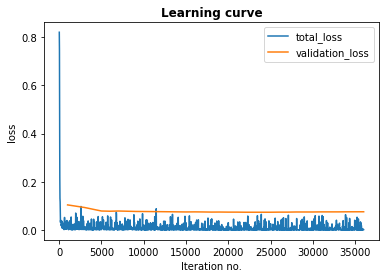

In [ ]:
import json
import matplotlib.pyplot as plt

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

# list of dicts
model_metrics = load_json_arr(model_name + '/metrics.json')

print(len(model_metrics))
print(model_metrics[56].keys())

plt.plot(
    [x['iteration'] for x in model_metrics if 'total_loss' in x], 
    [x['total_loss'] for x in model_metrics if 'total_loss' in x]
)

plt.plot(
    [x['iteration'] for x in model_metrics if 'validation_loss' in x], 
    [x['validation_loss'] for x in model_metrics if 'validation_loss' in x]
)

plt.xlabel('Iteration no.')
plt.ylabel('loss')
plt.title('Learning curve', fontweight ="bold")
plt.legend(['total_loss', 'validation_loss'], loc='upper right')
plt.ylim(0, 0.2)

plt.show()

## Plot mAP and F1 on the validation set

In [ ]:
plt.plot(
    [x['iteration'] for x in model_metrics if 'mAP' in x], 
    [x['mAP'] for x in model_metrics if 'mAP' in x]
)

plt.xlabel('Iteration no.')
plt.ylabel('mAP')
plt.title('mAP', fontweight ="bold")
plt.ylim(0, 1)

plt.show()

In [ ]:
plt.plot(
    [x['iteration'] for x in model_metrics if 'F1' in x], 
    [x['F1'] for x in model_metrics if 'F1' in x]
)

plt.xlabel('Iteration no.')
plt.ylabel('F1')
plt.title('F1', fontweight ="bold")
plt.ylim(0, 1)

plt.show()

# TensorBoard

In [ ]:
# Look at training curves in tensorboard:
%cd ModelOutput/
%load_ext tensorboard
%tensorboard --logdir faster_rcnn_R_101_FPN_3x_6COA
%cd ..

# Evaluation using the trained model

To run inference using the trained model on the validation/test dataset, we first create a predictor using the model we just trained.

In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # 0.7
#cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.5   # pg. 23 of Zhang et al.

predictor = DefaultPredictor(cfg)

## Visualization

We randomly select several samples to visualize the prediction results.

In [ ]:
#from detectron2.utils.visualizer import ColorMode

dataset_dicts = get_dict("test")   # must be "test", "test_offshore", "test_inshore"

# Filter out pics w/o annotations
dataset_dicts_anns = []
for i in dataset_dicts:
  if i['annotations'] != []:
    dataset_dicts_anns.append(i)

In [ ]:
def printImage(ann, metadata, predictor = None, predFlag = False):
  #from detectron2.utils.visualizer import Visualizer

  im = cv2.imread(ann["file_name"])
  v = Visualizer(im[:, :, ::-1], 
                 metadata=metadata, 
                 scale=0.5)
  
  if predFlag:
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  else:
    out = v.draw_dataset_dict(ann)
  
  image = out.get_image()[:, :, ::-1]

  return image

In [ ]:
os.makedirs(model_name + "/predImages", exist_ok=True)  # Make a directory for output images

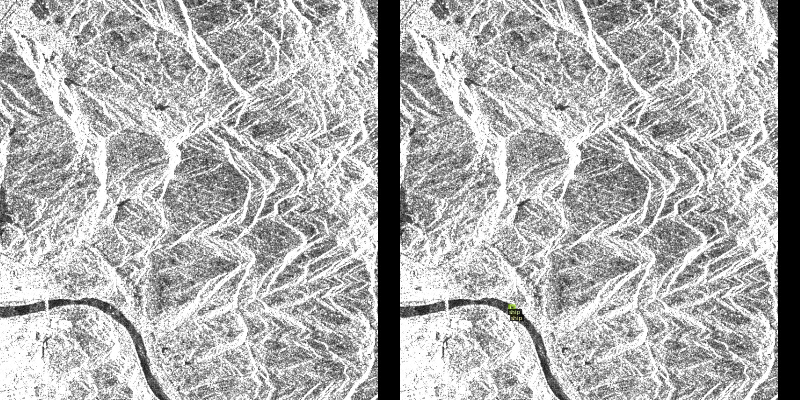

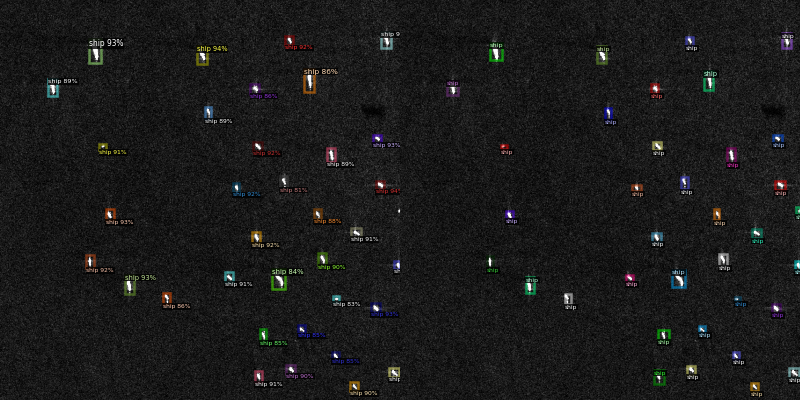

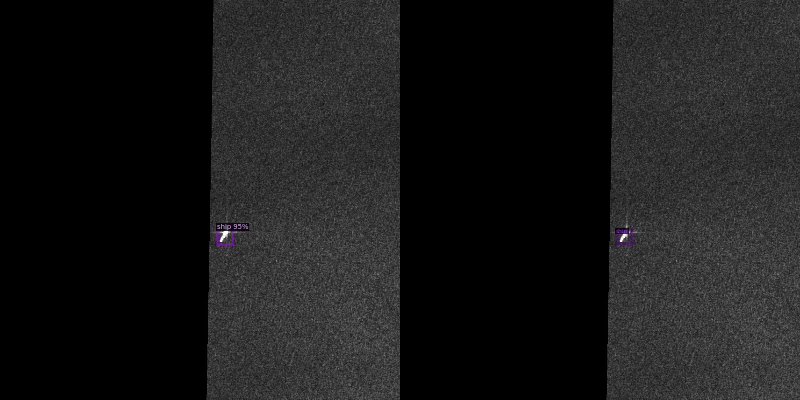

In [ ]:
from cv2 import hconcat
#random.seed(2)

num_samples = 3

for d in random.sample(dataset_dicts_anns, num_samples):
  image1 = printImage(d, test_metadata, predictor, True)  # Prediction
  image2 = printImage(d, test_metadata, False)  # Ground truth
  image3 = hconcat([image1, image2])

  cv2_imshow(image3)  # display an image
  cv2.imwrite(model_name + '/predImages/' + str(d["image_id"] + '.jpg'), image3)  # save an image

# Prediction

We can also evaluate its performance using AP metric implemented in COCO API.

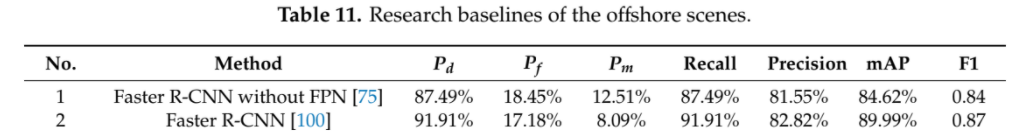

In [ ]:
#val = './datasets/test/'

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# test_offshore
evaluator = COCOEvaluator('ssdd_test_offshore', ('bbox',), False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, 'ssdd_test_offshore')

inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way to evaluate the model is to use `trainer.test`

[02/26 01:32:04 d2.evaluation.coco_evaluation]: 'ssdd_test_offshore' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[02/26 01:32:04 d2.data.datasets.coco]: Converting annotations of dataset 'ssdd_test_offshore' to COCO format ...)
[02/26 01:32:20 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[02/26 01:32:20 d2.data.datasets.coco]: Conversion finished, #images: 2234, #annotations: 1495
[02/26 01:32:20 d2.data.datasets.coco]: Caching COCO format annotations at './ModelOutput/faster_rcnn_R_101_FPN_3x_4C/ssdd_test_offshore_coco_format.json' ...
[02/26 01:32:21 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    ship    | 1495         |
|            |              |
[02/26 01:32:21 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[

In [ ]:
# test
evaluator = COCOEvaluator('ssdd_test', ('bbox',), False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, 'ssdd_test')

inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way to evaluate the model is to use `trainer.test`

In [ ]:
# test_inshore
evaluator = COCOEvaluator('ssdd_test_inshore', ('bbox',), False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, 'ssdd_test_inshore')

inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way to evaluate the model is to use `trainer.test`

In [ ]:
# train
evaluator = COCOEvaluator('ssdd_train', ('bbox',), False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, 'ssdd_train')

print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

In [ ]:
%ls ./ModelOutput/faster_rcnn_R_101_FPN_3x_6COA